## General Model



#### comments

## Import useful packages

In [27]:
import numpy as np
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import io
#from keras.utils import plot_model
import random
import yaml
#import ktrain
from astropy.io import ascii as ap_ascii
import seaborn as sns
import os

from helpers.visualize import chart_curves 

pd.set_option('display.float_format', lambda x: '%.5f' % x)



In [2]:
!ls -l


total 191680
-rw-rw-r-- 1 ubuntu ubuntu     1273 Oct 26 14:28 2304235_1.png
-rw-rw-r-- 1 ubuntu ubuntu      329 Oct 25 16:27 README.md
-rw-rw-r-- 1 ubuntu ubuntu    31676 Oct 26 19:27 Untitled.ipynb
drwxrwxr-x 2 ubuntu ubuntu     4096 Oct 26 14:46 __pycache__
-rw-rw-r-- 1 ubuntu ubuntu  3650473 Oct 25 16:27 cumulative_2020.10.19_16.12.52.csv
-rw-rw-r-- 1 ubuntu ubuntu      272 Oct 26 14:45 definitions.py
-rw-rw-r-- 1 ubuntu ubuntu   271302 Oct 25 16:27 eda.ipynb
-rw-rw-r-- 1 ubuntu ubuntu   226740 Oct 26 16:05 exoplanet_model.ipynb
-rw-rw-r-- 1 ubuntu ubuntu 31546781 Oct 25 16:27 full_tce_list.csv
-rw-rw-r-- 1 ubuntu ubuntu 11390972 Oct 25 16:27 full_tce_list_with_disposition_34032.csv
-rw-rw-r-- 1 ubuntu ubuntu 12452957 Oct 25 16:27 full_tce_list_with_disposition_and_av_34032.csv
-rw-rw-r-- 1 ubuntu ubuntu      937 Oct 25 16:27 get_light_curves.py
drwxrwxr-x 3 ubuntu ubuntu     4096 Oct 26 13:50 helpers
-rw-rw-r-- 1 ubuntu ubuntu 46576123 Oct 25 16:27 kplr_dr25_obs_robovetter_input.tx

In [3]:
!ls -l processed_data

total 245060
-rw-rw-r-- 1 ubuntu ubuntu       181 Oct 25 18:35 README.md
-rw-rw-r-- 1 ubuntu ubuntu       704 Oct 26 13:36 failed_kepids.csv
-rw-rw-r-- 1 ubuntu ubuntu       204 Oct 26 06:35 failed_kepids1.csv
-rw-rw-r-- 1 ubuntu ubuntu       234 Oct 26 05:46 failed_kepids2.csv
-rw-rw-r-- 1 ubuntu ubuntu       164 Oct 26 06:35 failed_kepids3.csv
-rw-rw-r-- 1 ubuntu ubuntu       114 Oct 26 05:38 failed_kepids4.csv
-rw-rw-r-- 1 ubuntu ubuntu 127159568 Oct 26 13:36 globalbinned_df.csv
-rw-rw-r-- 1 ubuntu ubuntu  24337627 Oct 26 06:35 globalbinned_df1.csv
-rw-rw-r-- 1 ubuntu ubuntu  24306649 Oct 26 05:46 globalbinned_df2.csv
-rw-rw-r-- 1 ubuntu ubuntu  24433578 Oct 26 06:35 globalbinned_df3.csv
-rw-rw-r-- 1 ubuntu ubuntu  24693250 Oct 26 05:38 globalbinned_df4.csv
-rw-rw-r-- 1 ubuntu ubuntu  12507236 Oct 26 13:36 localbinned_df.csv
-rw-rw-r-- 1 ubuntu ubuntu   2394841 Oct 26 06:35 localbinned_df1.csv
-rw-rw-r-- 1 ubuntu ubuntu   2397483 Oct 26 05:46 localbinned_df2.csv
-rw-rw-r-- 1 ubuntu 

In [133]:
PROCESSED_DATA_DIR='processed_data'
TCE_LIST='tce_table.csv'
FAILED_LIST='failed_kepids.csv'


In [134]:
#this excludes from tce_list those kepids and planet numbers that failed make_data process
processed=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,TCE_LIST))
print(processed.shape)
try:
    failed=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,FAILED_LIST))
    failed.columns=['kepid','tce_plnt_num']
    print(failed.shape)
    for index,row in failed.iterrows():
        processed.drop(processed[(processed.kepid==row.kepid) & 
                                 (processed.tce_plnt_num==row.tce_plnt_num)].index,inplace=True)
except:
    pass
    
processed.shape

(5000, 86)
(70, 2)


(4930, 86)

In [135]:
print(processed.koi_disposition.value_counts())

#combine confirmed and candidate
processed.replace({'koi_disposition':
                   {'CANDIDATE':'1-CONFIRMED','CONFIRMED':'1-CONFIRMED','FALSE POSITIVE':'0-FALSE POSITIVE'}},
                  inplace=True)
print(processed.koi_disposition.value_counts())

print('Baseline accuracy:', processed[processed.koi_disposition=='0-FALSE POSITIVE'].shape[0]/processed.shape[0])

FALSE POSITIVE    4384
CONFIRMED          274
CANDIDATE          272
Name: koi_disposition, dtype: int64
0-FALSE POSITIVE    4384
1-CONFIRMED          546
Name: koi_disposition, dtype: int64
Baseline accuracy: 0.8892494929006085


In [136]:
processed.koi_disposition

0       0-FALSE POSITIVE
1       0-FALSE POSITIVE
2       0-FALSE POSITIVE
3            1-CONFIRMED
4       0-FALSE POSITIVE
              ...       
4995    0-FALSE POSITIVE
4996    0-FALSE POSITIVE
4997    0-FALSE POSITIVE
4998    0-FALSE POSITIVE
4999         1-CONFIRMED
Name: koi_disposition, Length: 4930, dtype: object

In [137]:
LOCAL='localbinned_df.csv'
GLOBAL='globalbinned_df.csv'
x_local=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,LOCAL))
x_global=pd.read_csv(os.path.join(PROCESSED_DATA_DIR,GLOBAL))
print(x_local.shape)
print(x_global.shape)

(4930, 201)
(4930, 2001)


In [138]:
x_local.head(5)

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,-0.12883,-0.12883,0.11047,0.10683,0.10683,0.10683,0.16249,0.46529,0.46529,-0.48506,...,-0.19387,-0.37898,-0.26841,-0.26841,-0.26841,-0.26770,0.49615,0.49615,-0.28652,-1.00000
1,-0.64856,-0.66408,-0.67727,-0.54849,-0.47479,-0.55081,-0.33476,-0.29946,-0.43057,-0.27812,...,-0.19899,-0.17378,-0.44841,-0.45539,-0.39255,-0.65981,-0.75834,-0.67649,-0.68309,-0.72304
2,-0.54546,-0.52649,-0.54284,-0.56115,-0.54807,-0.55396,-0.58600,-0.55723,-0.59385,-0.60759,...,-0.13211,-0.16743,-0.20667,-0.25180,-0.30477,-0.35448,-0.37410,-0.38718,-0.39765,-0.41988
3,0.11573,0.11786,0.11786,0.11878,0.19217,0.19217,0.18334,0.05116,0.06091,0.03868,...,0.01218,0.04781,0.08132,0.04690,0.04507,-0.03213,-0.06578,-0.07264,0.02832,0.00609
4,0.83657,0.59813,1.12659,0.94575,0.83691,0.94910,0.68319,0.18687,0.26892,0.14200,...,-0.30543,0.22673,0.00435,-0.43252,-0.12224,0.18151,-0.01021,0.29571,0.51172,0.01792


In [139]:
#turn into numpy arrays/series
x_local=x_local.to_numpy()
x_global=x_global.to_numpy()
print(x_local.shape)
print(x_global.shape)

(4930, 201)
(4930, 2001)


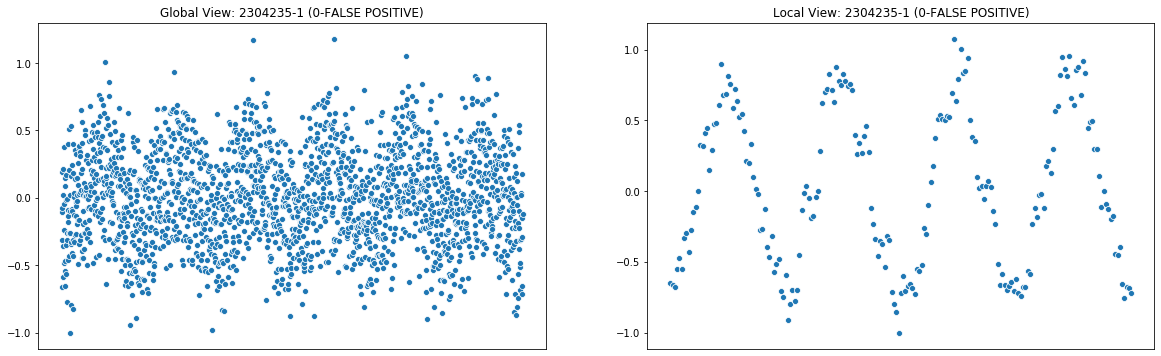

<Figure size 864x720 with 0 Axes>

In [140]:
#can print out charts

tce_number=1
chart_curves(processed.kepid[tce_number],processed.tce_plnt_num[tce_number],
             processed.koi_disposition[tce_number],
             x_global[tce_number],x_local[tce_number])

In [141]:
scaler_local = StandardScaler()
x_local= scaler_local.fit_transform(x_local)

scaler_global=StandardScaler()
x_global=scaler_global.fit_transform(x_global)

x_local

array([[-0.34718116, -0.35041927,  0.22017149, ...,  1.21741582,
        -0.72965968, -2.44372116],
       [-1.53650627, -1.60157999, -1.67158078, ..., -1.70891471,
        -1.71318242, -1.77389766],
       [-1.30055704, -1.279954  , -1.3487436 , ..., -0.98693601,
        -1.00526885, -1.04070963],
       ...,
       [-0.67003642, -1.23174738,  2.26811788, ...,  1.64025868,
         1.24555016,  1.4313727 ],
       [ 0.29332113,  0.21745481, -0.36282591, ...,  0.95580735,
         0.59856922,  0.10814751],
       [ 0.10139286,  0.40597791,  0.17507044, ..., -0.28931841,
         0.21536508,  0.47885393]])

In [142]:
#Conv1D layers take in tensors of dimension (length of vector = 201 or 2001, and dimensions of vector=1)
#So as with Conv2D in BW where need to add a color dimension here have to specify that there is only one
#dimension in each vector
x_local=np.expand_dims(x_local,axis=2)
x_global=np.expand_dims(x_global,axis=2)

print(x_local.shape)
print(x_global.shape)

(4930, 201, 1)
(4930, 2001, 1)


In [143]:
#turn output into categorical variable with encoding
Y=processed.koi_disposition
print(Y[0:10])
le=LabelEncoder()
le.fit(['1-CONFIRMED','0-FALSE POSITIVE'])
print(le.classes_)
Y=le.transform(Y)
print(Y[0:10])


0    0-FALSE POSITIVE
1    0-FALSE POSITIVE
2    0-FALSE POSITIVE
3         1-CONFIRMED
4    0-FALSE POSITIVE
5    0-FALSE POSITIVE
6         1-CONFIRMED
7    0-FALSE POSITIVE
8    0-FALSE POSITIVE
9    0-FALSE POSITIVE
Name: koi_disposition, dtype: object
['0-FALSE POSITIVE' '1-CONFIRMED']
[0 0 0 1 0 0 1 0 0 0]


In [144]:
# define two sets of inputs
tf.keras.backend.clear_session()
METRICS = [
          tf.keras.metrics.TruePositives(name='tp'),
          tf.keras.metrics.FalsePositives(name='fp'),
          tf.keras.metrics.TrueNegatives(name='tn'),
          tf.keras.metrics.FalseNegatives(name='fn'), 
          tf.keras.metrics.BinaryAccuracy(name='accuracy'),
          tf.keras.metrics.Precision(name='precision'),
          tf.keras.metrics.Recall(name='recall'),
          tf.keras.metrics.AUC(name='auc')
    ]


def make_model(metrics=METRICS,output_bias=None):
    input_local = tf.keras.layers.Input(shape=[x_local.shape[1],1])
    input_global=tf.keras.layers.Input(shape=[x_global.shape[1],1])

    #k_local = tf.keras.layers.BatchNormalization()(input_local)
    #k_local=tf.keras.layers.Conv1D(filters=16,kernel_size=5,activation='relu')(k_local)
    k_local=tf.keras.layers.Conv1D(filters=16,kernel_size=5,activation='relu')(input_local)

    k_local=tf.keras.layers.Conv1D(16,5,activation='relu')(k_local)
    k_local=tf.keras.layers.MaxPooling1D(pool_size=7,strides=2,padding='same')(k_local)
    k_local=tf.keras.layers.Conv1D(32,5,activation='relu')(k_local)
    k_local=tf.keras.layers.Conv1D(32,5,activation='relu')(k_local)
    k_local=tf.keras.layers.MaxPooling1D(pool_size=7,strides=2,padding='same')(k_local)
    k_local=tf.keras.layers.Flatten()(k_local)

    #k_global=tf.keras.layers.BatchNormalization()(input_global)
    #k_global=tf.keras.layers.Conv1D(filters=16,kernel_size=5,activation='relu')(k_global)
    k_global=tf.keras.layers.Conv1D(filters=16,kernel_size=5,activation='relu')(input_global)

    k_global=tf.keras.layers.Conv1D(16,5,activation='relu')(k_global)
    k_global=tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same')(k_global)
    k_global=tf.keras.layers.Conv1D(32,5,activation='relu')(k_global)
    k_global=tf.keras.layers.Conv1D(32,5,activation='relu')(k_global)
    k_global=tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same')(k_global)
    k_global=tf.keras.layers.Conv1D(64,5,activation='relu')(k_global)
    k_global=tf.keras.layers.Conv1D(64,5,activation='relu')(k_global)
    k_global=tf.keras.layers.MaxPooling1D(pool_size=5,strides=2,padding='same')(k_global)
    k_global=tf.keras.layers.Flatten()(k_global)

    #combines two branches
    k = tf.keras.layers.concatenate([k_local, k_global])

    k=tf.keras.layers.Dense(512,activation='relu')(k)
    k=tf.keras.layers.Dropout(.5)(k)
    k=tf.keras.layers.Dense(512,activation='relu')(k)
    k=tf.keras.layers.Dropout(.5)(k)
    k=tf.keras.layers.Dense(512,activation='relu')(k)
    k=tf.keras.layers.Dropout(.5)(k)
    k=tf.keras.layers.Dense(512,activation='relu')(k)
    #k=tf.keras.layers.Dropout(.6)(k)

    if output_bias is not None:
        output_bias=tf.keras.initializers.Constant(output_bias)
        
    output=tf.keras.layers.Dense(1,activation='sigmoid',bias_initializer=output_bias)(k)


    model=tf.keras.Model(inputs=[input_local,input_global],outputs=output)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy()
                  ,optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                  metrics=METRICS)

    #print (model.summary())
    return(model)

In [145]:
x_local_train, x_local_val, x_global_train, x_global_val, Y_train, Y_val = train_test_split(
    x_local,x_global, Y, test_size=0.2)

print(x_local_train.shape)
print(x_global_train.shape)
print(Y_train.shape)
print(x_local_val.shape)
print(x_global_val.shape)
print(Y_val.shape)


(3944, 201, 1)
(3944, 2001, 1)
(3944,)
(986, 201, 1)
(986, 2001, 1)
(986,)


In [146]:
EPOCHS = 20
BATCH_SIZE = 64

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [147]:
#work on setting initial bias
model=make_model()
model.predict([x_local_train[:10],x_global_train[:10]])

array([[0.17365636],
       [0.17841175],
       [0.17498267],
       [0.17403372],
       [0.17625244],
       [0.17572689],
       [0.17626174],
       [0.17552888],
       [0.17228323],
       [0.17436464]], dtype=float32)

In [148]:
results = model.evaluate([x_local_train,x_global_train],Y_train, batch_size=BATCH_SIZE, verbose=1)
print("Loss: {:0.4f}".format(results[0]))
neg, pos = np.bincount(Y)
total = neg + pos
print(neg,pos,total)
initial_bias=np.log([pos/neg])
initial_bias

3944/3944 [==============================] - 7s 2ms/sample - loss: 0.3638 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3507.0000 - fn: 437.0000 - accuracy: 0.8892 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4917
Loss: 0.3638
4384 546 4930


array([-2.08309785])

In [149]:
model = make_model(output_bias = initial_bias)
model.predict([x_local_train[:10],x_global_train[:10]])

array([[0.11184333],
       [0.11271536],
       [0.11141064],
       [0.11100477],
       [0.11114534],
       [0.11106362],
       [0.10962041],
       [0.11228878],
       [0.11056609],
       [0.11107285]], dtype=float32)

In [150]:
results = model.evaluate([x_local_train,x_global_train],Y_train, batch_size=BATCH_SIZE, verbose=1)
print("Loss: {:0.4f}".format(results[0]))

3944/3944 [==============================] - 7s 2ms/sample - loss: 0.3480 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 3507.0000 - fn: 437.0000 - accuracy: 0.8892 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5866
Loss: 0.3480


In [151]:
MODEL_DIR='models'
initial_weights = os.path.join(MODEL_DIR,'initial_weights')
model.save_weights(initial_weights)

In [152]:
model=make_model()
model.load_weights(initial_weights)

history=model.fit([x_local_train,x_global_train],
                  Y_train,
                  validation_data=([x_local_val,x_global_val],Y_val),
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  callbacks=[early_stopping],
                  verbose=1)

Train on 3944 samples, validate on 986 samples
Epoch 1/20
3944/3944 [==============================] - 22s 6ms/sample - loss: 0.2551 - tp: 91.0000 - fp: 43.0000 - tn: 3464.0000 - fn: 346.0000 - accuracy: 0.9014 - precision: 0.6791 - recall: 0.2082 - auc: 0.8752 - val_loss: 0.1977 - val_tp: 60.0000 - val_fp: 20.0000 - val_tn: 857.0000 - val_fn: 49.0000 - val_accuracy: 0.9300 - val_precision: 0.7500 - val_recall: 0.5505 - val_auc: 0.9378
Epoch 2/20
3944/3944 [==============================] - 18s 5ms/sample - loss: 0.1707 - tp: 257.0000 - fp: 75.0000 - tn: 3432.0000 - fn: 180.0000 - accuracy: 0.9353 - precision: 0.7741 - recall: 0.5881 - auc: 0.9451 - val_loss: 0.1783 - val_tp: 72.0000 - val_fp: 25.0000 - val_tn: 852.0000 - val_fn: 37.0000 - val_accuracy: 0.9371 - val_precision: 0.7423 - val_recall: 0.6606 - val_auc: 0.9448
Epoch 3/20
3944/3944 [==============================] - 19s 5ms/sample - loss: 0.1581 - tp: 275.0000 - fp: 83.0000 - tn: 3424.0000 - fn: 162.0000 - accuracy: 0.9379 -

In [56]:
model.evaluate([x_local_train,x_global_train],Y_train,verbose=1)
model.evaluate([x_local_val,x_global_val],Y_val,verbose=1)

986/986 [==============================] - 1s 1ms/sample - loss: 0.1558 - tp: 860.0000 - fp: 28.0000 - tn: 76.0000 - fn: 22.0000 - accuracy: 0.9493 - precision: 0.9685 - recall: 0.9751 - auc: 0.9590


[0.15579329101599254,
 860.0,
 28.0,
 76.0,
 22.0,
 0.94929004,
 0.9684685,
 0.9750567,
 0.9590256]

In [100]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'accuracy', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

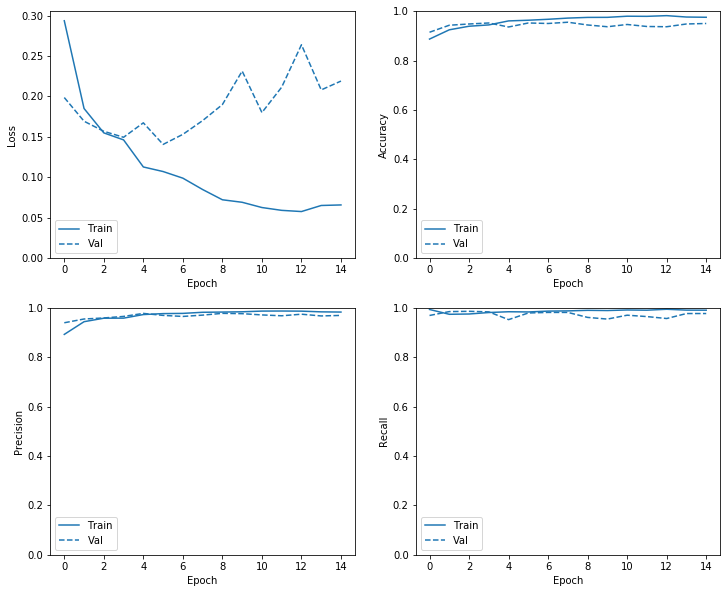

In [101]:
plot_metrics(history)

In [165]:
#confusion matrix
from sklearn.metrics import confusion_matrix
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Not Planets Properly Categorized (True Negatives): ', cm[0][0])
  print('Not Planets Categorized as Planets Detected (False Positives): ', cm[0][1])
  print('Planets Missed (False Negatives): ', cm[1][0])
  print('Planets Properly Categorized (True Positives): ', cm[1][1])
  print('Total Planets: ', np.sum(cm[1]))

loss :  0.1058009666963112
tp :  372.0
fp :  95.0
tn :  3412.0
fn :  65.0
accuracy :  0.95943207
precision :  0.7965739
recall :  0.8512586
auc :  0.9798314

Not Planets Properly Categorized (True Negatives):  851
Not Planets Categorized as Planets Detected (False Positives):  26
Planets Missed (False Negatives):  29
Planets Properly Categorized (True Positives):  80
Total Not Planets:  109


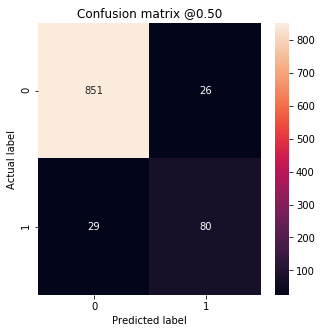

In [156]:
#train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)

val_predictions_baseline = model.predict([x_local_val,x_global_val], batch_size=BATCH_SIZE)
train_predictions_baseline = model.predict([x_local_train,x_global_train], batch_size=BATCH_SIZE)

baseline_results = model.evaluate([x_local_train,x_global_train],Y_train,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(Y_val, val_predictions_baseline)

In [158]:
from sklearn.metrics import roc_curve

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

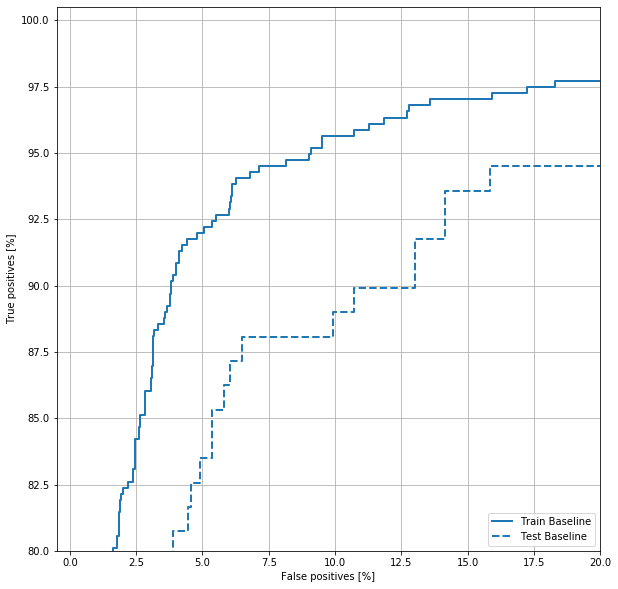

In [160]:
plot_roc("Train Baseline", Y_train, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", Y_val, val_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [161]:
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.56
Weight for class 1: 4.51


In [162]:
tf.keras.backend.clear_session()
model=make_model()
#model.load_weights(initial_weights)

weighted_history=model.fit([x_local_train,x_global_train],
                  Y_train,
                  validation_data=([x_local_val,x_global_val],Y_val),
                  epochs=EPOCHS,
                  batch_size=BATCH_SIZE,
                  class_weight=class_weight,
                  callbacks=[early_stopping],
                  verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3944 samples, validate on 986 samples
Epoch 1/20
3944/3944 [==============================] - 23s 6ms/sample - loss: 0.5647 - tp: 278.0000 - fp: 710.0000 - tn: 2797.0000 - fn: 159.0000 - accuracy: 0.7797 - precision: 0.2814 - recall: 0.6362 - auc: 0.8109 - val_loss: 0.3763 - val_tp: 82.0000 - val_fp: 70.0000 - val_tn: 807.0000 - val_fn: 27.0000 - val_accuracy: 0.9016 - val_precision: 0.5395 - val_recall: 0.7523 - val_auc: 0.9402
Epoch 2/20
3944/3944 [==============================] - 19s 5ms/sample - loss: 0.3053 - tp: 392.0000 - fp: 388.0000 - tn: 3119.0000 - fn: 45.0000 - accuracy: 0.8902 - precision: 0.5026 - recall: 0.8970 - auc: 0.9437 - val_loss: 0.2879 - val_tp: 99.0000 - val_fp: 95.0000 - val_tn: 782.0000 - val_fn: 10.0000 - val_accuracy: 0.8935 - val_precision: 0.5103 - val_recall: 0.9083 - val_auc: 0.9511
Epoch 3/20
3944/3944 [==============================] - 19s 5ms/sample - loss: 0.2693 - tp: 401.0000 - fp: 330.000

loss :  0.1841216412265209
tp :  428.0
fp :  317.0
tn :  3190.0
fn :  9.0
accuracy :  0.9173428
precision :  0.5744966
recall :  0.97940505
auc :  0.9874564

Not Planets Properly Categorized (True Negatives):  773
Not Planets Categorized as Planets Detected (False Positives):  104
Planets Missed (False Negatives):  8
Planets Properly Categorized (True Positives):  101
Total Not Planets:  109


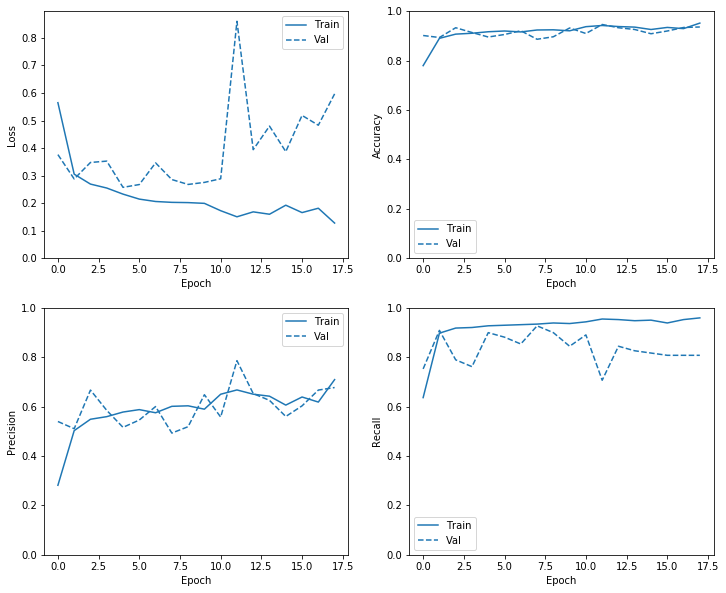

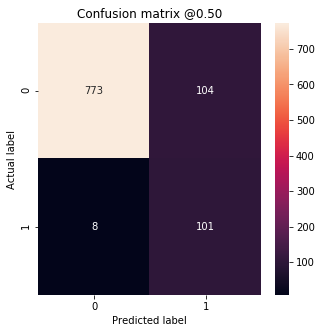

In [164]:
plot_metrics(weighted_history)
val_predictions_baseline = model.predict([x_local_val,x_global_val], batch_size=BATCH_SIZE)
train_predictions_baseline = model.predict([x_local_train,x_global_train], batch_size=BATCH_SIZE)

baseline_results = model.evaluate([x_local_train,x_global_train],Y_train,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(Y_val, val_predictions_baseline)

In [170]:
#oversampling
bool_train_labels = Y_train != 0
pos_features_local = x_local_train[bool_train_labels]
neg_features_local = x_local_train[~bool_train_labels]
pos_features_global = x_global_train[bool_train_labels]
neg_features_global = x_global_train[~bool_train_labels]

pos_labels = Y_train[bool_train_labels]
neg_labels = Y_train[~bool_train_labels]

In [174]:
ids = np.arange(len(pos_features_local))
choices = np.random.choice(ids, len(neg_features_local))

res_pos_features_local = pos_features_local[choices]
res_pos_features_global = pos_features_global[choices]
res_pos_labels = pos_labels[choices]

print(res_pos_features_local.shape,res_pos_features_global.shape)

(3507, 201, 1) (3507, 2001, 1)


In [181]:
res_features_local=np.concatenate([res_pos_features_local,neg_features_local],axis=0)
res_features_global=np.concatenate([res_pos_features_global,neg_features_global],axis=0)
res_labels=np.concatenate([res_pos_labels,neg_labels],axis=0)
order=np.arange(len(res_labels))
np.random.shuffle(order)
res_features_local=res_features_local[order]
res_features_global=res_features_global[order]
res_labels=res_labels[order]
print(res_features_local.shape,res_features_global.shape,res_labels.shape)

(7014, 201, 1) (7014, 2001, 1) (7014,)


In [ ]:
tf.keras.backend.clear_session()
resampled_model=make_model()
resampled_history = resampled_model.fit(
        [res_features_local,res_features_global],
        res_labels,
        validation_data=([x_local_val,x_global_val],Y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[early_stopping],
        verbose=2)


In [ ]:
plot_metrics(resampled_model)
val_predictions_baseline = model.predict([x_local_val,x_global_val], batch_size=BATCH_SIZE)
train_predictions_baseline = model.predict([x_local_train,x_global_train], batch_size=BATCH_SIZE)

baseline_results = model.evaluate([x_local_train,x_global_train],Y_train,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(Y_val, val_predictions_baseline)

In [62]:
np.set_printoptions(suppress=True)
Y_val_pred=model.predict([x_local_val,x_global_val])
print(Y_val_pred.shape)
print(Y_val_pred[0:30])
print(Y_val[0:30])

(986, 1)
[[1.        ]
 [0.9592259 ]
 [0.9999994 ]
 [0.98998755]
 [0.03937406]
 [1.        ]
 [0.9993449 ]
 [0.9999541 ]
 [0.9986337 ]
 [0.81464547]
 [0.88243836]
 [0.5429766 ]
 [0.99783427]
 [1.        ]
 [0.97419953]
 [0.9989348 ]
 [0.03919312]
 [0.99962485]
 [0.9917487 ]
 [0.9992415 ]
 [0.9989913 ]
 [0.99997437]
 [0.9956975 ]
 [0.99999416]
 [0.999992  ]
 [0.99962926]
 [0.9906729 ]
 [0.2439829 ]
 [0.99999666]
 [1.        ]]
[1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1]


In [63]:
from sklearn.metrics import classification_report

Y_val_pred_bool = np.argmax(Y_val_pred, axis=1)

print(classification_report(Y_val, Y_val_pred_bool))

              precision    recall  f1-score   support

           0       0.11      1.00      0.19       104
           1       0.00      0.00      0.00       882

    accuracy                           0.11       986
   macro avg       0.05      0.50      0.10       986
weighted avg       0.01      0.11      0.02       986



/home/ubuntu/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
np.bincount(Y_val)

array([104, 882])

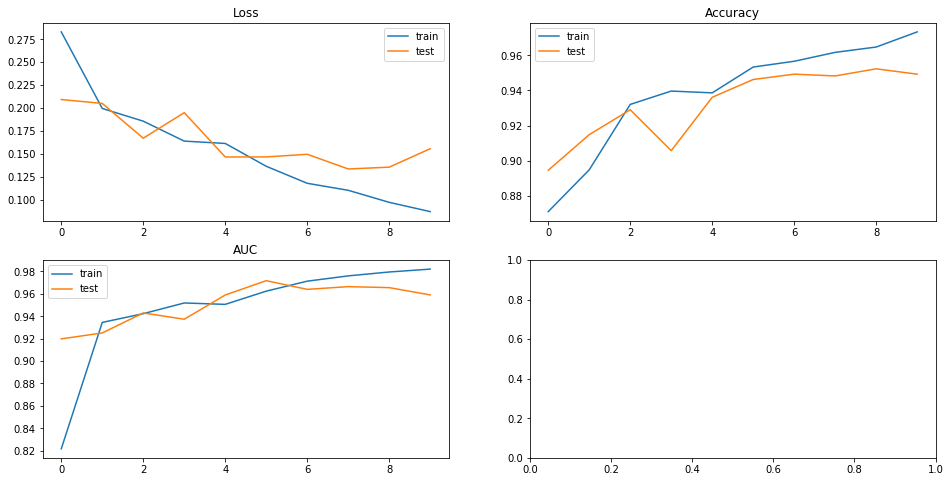

In [61]:
import matplotlib.pyplot as plt
fig,axes=plt.subplots(2,2,figsize=(16,8))
plt.subplot(221)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(222)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

plt.subplot(223)
plt.title('AUC')
plt.plot(history.history['auc'], label='train')
plt.plot(history.history['val_auc'], label='test')
plt.legend()
plt.show()

In [ ]:
# the first branch operates on the first input
x = Dense(8, activation="relu")(inputA)
x = Dense(4, activation="relu")(x)
x = Model(inputs=inputA, outputs=x)
# the second branch opreates on the second input
y = Dense(64, activation="relu")(inputB)
y = Dense(32, activation="relu")(y)
y = Dense(4, activation="relu")(y)
y = Model(inputs=inputB, outputs=y)
# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(2, activation="relu")(combined)
z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input], outputs=z)

In [ ]:
#model splits into lat long after convolutional layers

input_shape=(270,480,1)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(inputs)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
input = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Flatten()(x)

xlat=tf.keras.layers.Dense(256,activation='relu')(x)
xlat=tf.keras.layers.Dropout(0.5)(xlat)
xlat=tf.keras.layers.Dense(64,activation='relu')(xlat)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(xlat)  

xlong=tf.keras.layers.Dense(256,activation='relu')(x)
xlong=tf.keras.layers.Dropout(0.5)(xlong)
xlong=tf.keras.layers.Dense(64,activation='relu')(xlong)
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(xlong)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [ ]:
with open('model.yml') as config_file:
    config_data = yaml.load(config_file)
    image_dir = config_data['image_dir']
    latstart= config_data['latstart']
    latend=config_data['latend']
    longstart = config_data['longstart']
    longend=config_data['longend']
    dtstart= config_data['dtstart']
    dtend=config_data['dtend']

## Define functions to load the data


#### comment


### Key image read-in functions: load_image and build_input

In [ ]:
def load_image(s3_client,bucket_name,file_name, dim=(224,224)):
    """
    Loads a single image as a Numpy array and resizes it as
    desired.  The default dimensions are consistent with
    those expected by the VGG models.  

    Args:
    s3_client:  s3 resource
    bucket_name:name of bucket
    file_name:  file to convert to image

    dim: Two-element tuple giving the desired height
         and width of the processed image

    Returns:
    image:  A single-channel Numpy array
    """
    #image = cv2.imread(image_path, 0)
    file_stream = io.BytesIO()
    s3.download_fileobj(bucket_name,file_name,file_stream)
    nparr = np.frombuffer(file_stream.getvalue(), np.uint8)
    image=cv2.imdecode(nparr,0)
    image = cv2.resize(image, dim)#, interpolation = cv2.INTER_AREA)
    return image

In [ ]:
def build_input(s3_client,bucket_name,file_list,files_to_load,dim):
    """
    Loads all of the images into a single numpy array.
    Assumes that there are 101 equally-spaced images
    spanning lattitudes from 35N to 45N.  

    Args:
    s3_client:  s3 resource
    bucket_name:name of bucket
    file_list:  list of files in bucket
    Returns:
    X:  A 3-dimensional numpy array containing the
        images. Image height and width are set by
        `load_images` and default to 224 x 224.

    y:  A 1-dimensional numpy array of target lattitudes.
    """
    X = []
    i=0
    for file in file_list[0:files_to_load]:
        if file[-4:] == '.png':
            print(file)
            image = load_image(s3_client,bucket_name,file,dim)
            X.append(image)
            if i%100==0:
                print('loaded:',i)
            i+=1
    return (np.array(X) / 255)

In [ ]:
def build_labels(file_list,files_to_load):
    y = []
    t=[]
    for file in file_list[0:files_to_load]:
        if file[-4:] == '.png':
            file_split = file.split('+')
            lat = float(file_split[0])
            long = float(file_split[1])
            time = file_split[2].split('.')[0]
            y.append((lat, long))
            t.append(time)
    return np.array(y),np.array(t)

#### Test load_image on one image manually

In [ ]:
bucket_name='w251-final-project'
file_name='36.0014762509164+-74.82905304191733+2020-05-26T01:10:59.png'
s3 = boto3.client('s3')
sample_image = load_image(s3,bucket_name,file_name)
plt.imshow(sample_image)
print(sample_image.shape)
file_list=[file_name]
test_label, test_time=build_labels(file_list,1)
print (test_label,test_time)

## Prepare the data

### Load the images

In [ ]:
#clear out models for memory management purposes
tf.keras.backend.clear_session()

#change this to true to force it to reload from S3 bucket
force_load=False

#check if np arrays have already been saved and load if so
if ((os.path.exists('x.npy'))&(not force_load)):
    print('loading from files')
    X=np.load('x.npy')
    y=np.load('y.npy')
    t=np.load('t.npy')

#otherwise go to S3 bucket
else:
    print('loading from S3')
    bucket_name='w251-final-project'
    file_list=get_matching_s3_keys(bucket_name)
    
    #shuffle file list so that if take less than all are distributed.  also makes array randomly shuffled
    random.shuffle(file_list)
    
    s3 = boto3.client('s3')

    #max_files=100000
    max_files=500
    file_list_length=len(file_list)
    files_to_load=np.minimum(max_files,file_list_length)

    #get images
    print('About to call build_input on',files_to_load,' files')
    dim=(224,224)
    X = build_input(s3,bucket_name,file_list,files_to_load,dim)


    #get labels
    print ('Building labels')
    y,t = build_labels(file_list,files_to_load)
    
    print ('saving arrays so can reload more easily next time through')
    np.save('x.npy',X)
    np.save('y.npy',y)
    np.save('t.npy',t)

print ('shape of image array:', X.shape)
print ('shape of label list:', y.shape)
print ('shape of time list:',t.shape)


### Standardize the values

In [ ]:
def scale_down(numbers,top,bottom):
    number_range=top-bottom
    revised=[x-bottom for x in numbers]
    revised=[x/number_range for x in revised]
    return revised

def scale_up(number,top,bottom):
    number_range=top-bottom
    revised=number*number_range
    revised=revised+bottom
    return revised


In [ ]:
#just scaling down without normalizing
y[:,0]=scale_down(y[:,0],latend,latstart)
y[:,1]=scale_down(y[:,1],longend,longstart)

#y[:,0] = scale(y[:,0])
#y[:,1]=scale(y[:,1])

print (y[:,0].mean(),y[:,0].std())
print (y[:,1].mean(),y[:,1].std())

### Split into test and training sets

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)


In [ ]:
print(X_train[0].shape)
print (X_train[0])
print (X_train[0].max())
print (X_train[0].mean())

### Add channel for CNN

In [ ]:
#need to add channel for B&W for CNN
#https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/

print(X_train.shape,y_train.shape)
X_train=np.expand_dims(X_train,axis=3)
X_val=np.expand_dims(X_val,axis=3)
print(X_train.shape,X_val.shape)

## The model


In [ ]:
#just dense

input_shape=(224,224,1)
input_image = tf.keras.layers.Input(shape=X_train[0].shape)
input_time=input_time=tf.keras.layers.Input(shape=t_train[0].shape)
i=tf.keras.layers.Flatten()(input_image)
i=tf.keras.layers.Dense(528,activation='relu')(i)
i=tf.keras.layers.Dense(528,activation='relu')(i)
i=tf.keras.layers.Dense(528,activation='relu')(i)

t=tf.keras.layers.Flatten()(input_time)
it=tf.keras.layers.concatenate([i,t])

xlat=tf.keras.layers.Dense(256,activation='relu')(it)
xlat=tf.keras.layers.Dropout(0.25)(xlat)
xlat=tf.keras.layers.Dense(256,activation='relu')(xlat)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(xlat)  

xlong=tf.keras.layers.Dense(256,activation='relu')(it)
xlong=tf.keras.layers.Dropout(0.25)(xlong)
xlong=tf.keras.layers.Dense(256,activation='relu')(xlong)
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(xlong)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model([input_image,input_time], model_output)







In [ ]:
losses = ['mean_squared_error','mean_squared_error']
metrics = ['mean_squared_error','mean_squared_error']

model.compile(optimizer='Adam',
                 loss=losses,
                 metrics=metrics)

print(model.summary())


### Fit the model

In [ ]:
tf.keras.backend.clear_session()
history = model.fit(x=[X_train,t_train], 
                    y=[y_train[:,0],y_train[:,1]],
                    validation_data=[[X_val,t_val],[y_val[:,0],y_val[:,1]]],
                    verbose=1, epochs=15, batch_size=32)

    


### Evaluate model performance

In [ ]:
history_df = pd.DataFrame(history.history)
ax = history_df.plot(y=['loss', 'val_loss'],
                xticks=np.linspace(0, len(history_df), 6))
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_title('Evolution of Mean Squared Error')
plt.show()


In [ ]:
print(X_val.shape)
print(y_val.shape)

In [ ]:
y_hat = model.predict([X_val,t_val])
#y_hat_lat=model.predict(X_val)[0]
#y_hat_long=model.predict(X_val)[1]
y_hat_lat=y_hat[:,0]
y_hat_long=y_hat[:,1]

y_hat_lat=scale_up(y_hat_lat,latend,latstart)
y_hat_long=scale_up(y_hat_long,longend,longstart)

y_val_lat=y_val[:,0]
y_val_long=y_val[:,1]

y_val_lat=scale_up(y_val_lat,latend,latstart)
y_val_long=scale_up(y_val_long,longend,longstart)

In [ ]:
fig = plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)
ax.scatter(y_val_lat, y_hat_lat)
plt.title('Predicted lat vs. True lat')
plt.xlabel('True lat')
plt.ylabel('Predicted lat')
ax.set_xlim(36,40)
ax.set_ylim(36,40)
#draw straight line


In [ ]:
fig = plt.figure(figsize=(12,6))
ax=fig.add_subplot(111)
ax.scatter(y_val_long, y_hat_long)
plt.title('Predicted long vs. True long')
plt.xlabel('True long')
plt.ylabel('Predicted long')
ax.set_xlim(-78,-74)
ax.set_ylim(-78,-74)


### Save Model

In [ ]:
model_dir='inference_model'
model.save(model_dir)


In [ ]:
test_model=tf.keras.models.load_model(model_dir)


In [ ]:
def upload_model(model_dir,bucket_name):
    #s3_client=boto3.client('s3')
    session = boto3.Session()
    s3 = session.resource('s3')
    bucket = s3.Bucket(bucket_name)
    for subdir, dirs, files in os.walk(model_dir):
        for file in files:
            full_path = os.path.join(subdir, file)
            with open(full_path, 'rb') as data:
                bucket.put_object(Key=full_path[len(model_dir)+1:], Body=data)

bucket_name='w251-final-project-model'
upload_model(model_dir,bucket_name)

In [ ]:
input_image = tf.keras.layers.Input(shape=X_train[0].shape)
input_time=tf.keras.layers.Input(shape=t_train[0].shape)

i=tf.keras.layers.Conv2D(filters=5,kernel_size=10,padding='same',activation='relu')(input_image)
i=tf.keras.layers.Conv2D(filters=1,kernel_size=10,padding='same',activation='relu') (i)
i=tf.keras.layers.Flatten()(i)

t=tf.keras.layers.Flatten()(input_time)
ti=tf.keras.layers.concatenate([i,t])
ti=tf.keras.layers.Dense(256,activation='relu')(ti)
ti=tf.keras.layers.Dropout(0.2)(ti)
outputs=tf.keras.layers.Dense(2,activation='sigmoid')(ti)

model = tf.keras.Model(inputs=[input_image, input_time], outputs=outputs)


lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

model.compile(optimizer=optimizer,
                 loss=haversine_loss)

print(model.summary())

history = model.fit(x=[X_train,t_train], 
                    y=[y_train],
                    validation_data=[[X_val,t_val],y_val],
                    verbose=1, epochs=15, batch_size=64)


### Feed Forward Dense

In [ ]:
#just dense

input_shape=(224,224,1)
inputs = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Flatten()(inputs)
x=tf.keras.layers.Dense(528,activation='relu')(x)
x=tf.keras.layers.Dense(528,activation='relu')(x)
x=tf.keras.layers.Dense(528,activation='relu')(x)

xlat=tf.keras.layers.Dense(256,activation='relu')(x)
xlat=tf.keras.layers.Dropout(0.25)(xlat)
xlat=tf.keras.layers.Dense(256,activation='relu')(xlat)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(xlat)  

xlong=tf.keras.layers.Dense(256,activation='relu')(x)
xlong=tf.keras.layers.Dropout(0.25)(xlong)
xlong=tf.keras.layers.Dense(256,activation='relu')(xlong)
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(xlong)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)
print(model.summary())

In [ ]:
history = model.fit(x=X_train, 
                    y=[y_train[:,0],y_train[:,1]],
                    validation_data=[X_val,[y_val[:,0],y_val[:,1]]],
                    verbose=1, epochs=20, batch_size=128)

In [ ]:
y_hat = model.predict(X_val)
#y_hat_lat=model.predict(X_val)[0]
#y_hat_long=model.predict(X_val)[1]
y_hat_lat=y_hat[0]
y_hat_long=y_hat[1]

y_hat_lat=scale_up(y_hat_lat,toplat,bottomlat)
y_hat_long=scale_up(y_hat_long,toplong,bottomlong)

y_val_lat=y_val[:,0]
y_val_long=y_val[:,1]

y_val_lat=scale_up(y_val_lat,toplat,bottomlat)
y_val_long=scale_up(y_val_long,toplong,bottomlong)

In [ ]:
plt.scatter(y_val_lat, y_hat_lat)
plt.title('Predicted lat vs. True lat')
plt.xlabel('True lat')
plt.ylabel('Predicted lat')
plt.show()

In [ ]:
plt.scatter(y_val_long, y_hat_long)
plt.title('Predicted long vs. True long')
plt.xlabel('True long')
plt.ylabel('Predicted long')
plt.show()

### Things to consider doing:
- don't normalize the lat and long - just scale it DONE
- convert back to lat and long DONE
- set validation batch size to deal with OOM errors (possibly) DONE
- loss weights?
- what is resolution of png files coming in?  are they squares?
- since set wide rectangle, need to make sure entirely at night time
- change angle of view - look more tired horizon?


### Old models

In [ ]:
# Define Input layer(s)
inputShape = (224, 224)
inputs = tf.keras.layers.Input(shape=inputShape)

flatten = tf.keras.layers.Flatten()(inputs)

x=tf.keras.layers.Dense(512,activation='relu')(flatten)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(x)  
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(x)


# Build and compile model
model_input = inputs
model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(model_input, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [ ]:
#model splits into lat long after convolutional layers

input_shape=(270,480,1)
input = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(inputs)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Flatten()(x)

xlat=tf.keras.layers.Dense(256,activation='relu')(x)
xlat=tf.keras.layers.Dropout(0.5)(xlat)
xlat=tf.keras.layers.Dense(64,activation='relu')(xlat)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(xlat)  

xlong=tf.keras.layers.Dense(256,activation='relu')(x)
xlong=tf.keras.layers.Dropout(0.5)(xlong)
xlong=tf.keras.layers.Dense(64,activation='relu')(xlong)
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(xlong)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [ ]:
input_shape=(224,224,1)
inputs = tf.keras.layers.Input(shape=input_shape)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(inputs)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(64,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Conv2D(128,(3,3),activation='relu')(x)
x=tf.keras.layers.MaxPooling2D((2,2))(x)
x=tf.keras.layers.Dropout(0.25)(x)

x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(256,activation='relu')(x)
x=tf.keras.layers.Dropout(0.5)(x)
x=tf.keras.layers.Dense(64,activation='relu')(x)
regression_layer_lat = tf.keras.layers.Dense(1, name='regression_lat')(x)  
regression_layer_long = tf.keras.layers.Dense(1, name='regression_long')(x)

model_output = [regression_layer_lat, regression_layer_long]
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224)),
    tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    #tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    #tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2)
])

In [ ]:
losses = ['mean_squared_error', 'mean_squared_error']
metrics = ['mean_squared_error', 'mean_squared_error']

model = tf.keras.models.Model(inputs, model_output)
model.compile(loss=losses,  optimizer='adam', metrics=metrics)